In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import seaborn as sns

In [19]:
df = pd.read_csv("processed_data/cleaned_data.csv")

In [ ]:
NUM_COLS = df.select_dtypes(include=['float64']).drop(columns=['ClosePrice'], errors='ignore').columns.tolist()
CAT_COLS = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical Features: {NUM_COLS}")
print(f"Categorical Features: {CAT_COLS}")

X = df[NUM_COLS + CAT_COLS]
y = np.log1p(df['ClosePrice'])

numeric features: ['Latitude', 'Longitude', 'LivingArea', 'FireplacesTotal', 'AboveGradeFinishedArea', 'YearBuilt', 'StreetNumberNumeric', 'BathroomsTotalInteger', 'BuildingAreaTotal', 'BedroomsTotal', 'ElementarySchoolDistrict', 'CoveredSpaces', 'Stories', 'GarageSpaces', 'LotSizeSquareFeet', 'MiddleOrJuniorSchoolDistrict', 'SalesTaxRate', 'UNRATE', 'MORTGAGE30US', 'FEDFUNDS', 'CPIAUCNS', 'Age', 'LotDensity', 'index_right', 'SchoolDistrictID']
categorical features: ['WaterfrontYN', 'BasementYN', 'CloseDate', 'UnparsedAddress', 'PropertyType', 'CountyOrParish', 'ElementarySchool', 'PropertySubType', 'City', 'StateOrProvince', 'MiddleOrJuniorSchool', 'HighSchool', 'Levels', 'HighSchoolDistrict', 'PostalCode', 'CloseDate_Parsed', 'CloseDate_YearMonth', 'FlooringType', 'District']


In [21]:
df = df[df['ClosePrice'].notna()]
drop_cols = [
    'CloseDate', 'UnparsedAddress', 'CloseDate_Parsed', 'CloseDate_YearMonth', 'index_right',
    'WaterfrontYN', 'BasementYN'
]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [22]:
y = np.log1p(df['ClosePrice'])
df = df.drop(columns=['ClosePrice'])

In [23]:
numerical = [
    'LivingArea', 'GarageSpaces', 'ParkingTotal', 'LotSizeSquareFeet',
    'FireplacesTotal', 'BedroomsTotal', 'BathroomsTotalInteger',
    'SalesTaxRate', 'UNRATE', 'MORTGAGE30US', 'FEDFUNDS', 'CPIAUCNS',
    'Age', 'LotDensity'
]
binary = [
    'ViewYN', 'PoolPrivateYN', 'AttachedGarageYN', 'FireplaceYN', 'NewConstructionYN'
]
categorical = [
    'City', 'CountyOrParish', 'PostalCode', 'Levels', 'StateOrProvince',
    'PropertySubType', 'HighSchoolDistrict', 'District', 'FlooringType'
]

In [24]:
numerical = [col for col in numerical if col in df.columns]
binary = [col for col in binary if col in df.columns]
categorical = [col for col in categorical if col in df.columns]

# fill NaNs
df[numerical] = df[numerical].fillna(df[numerical].median())
df[binary] = df[binary].fillna(0).astype(int)
df[categorical] = df[categorical].fillna("Unknown")

In [ ]:
X = df[numerical + binary + categorical]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_actual = np.expm1(y_train)
sample_weights = np.log1p(y_train_actual)

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical + binary),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical)
    ]
)

### Optimize Parameters


In [ ]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", HistGradientBoostingRegressor(
        max_iter=300,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    ))
])

In [ ]:
param_distributions = {
    "regressor__learning_rate": uniform(0.01, 0.2),
    "regressor__max_iter": randint(500, 2000),
    "regressor__max_leaf_nodes": randint(20, 150),
    "regressor__max_depth": randint(3, 10),
    "regressor__min_samples_leaf": randint(10, 100),
    "regressor__l2_regularization": uniform(0.0, 5.0)
}

In [ ]:
search = RandomizedSearchCV(
    model,  # 用你原本的 Pipeline
    param_distributions=param_distributions,
    scoring="r2",
    n_iter=50,
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

search.fit(X_train, y_train, regressor__sample_weight=sample_weights)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END regressor__l2_regularization=1.8727005942368125, regressor__learning_rate=0.20014286128198325, regressor__max_depth=5, regressor__max_iter=1595, regressor__max_leaf_nodes=40, regressor__min_samples_leaf=92; total time= 3.7min
[CV] END regressor__l2_regularization=1.8727005942368125, regressor__learning_rate=0.20014286128198325, regressor__max_depth=5, regressor__max_iter=1595, regressor__max_leaf_nodes=40, regressor__min_samples_leaf=92; total time= 3.7min
[CV] END regressor__l2_regularization=0.4998745790900144, regressor__learning_rate=0.10184977839317343, regressor__max_depth=7, regressor__max_iter=1623, regressor__max_leaf_nodes=123, regressor__min_samples_leaf=33; total time= 3.7min
[CV] END regressor__l2_regularization=1.8727005942368125, regressor__learning_rate=0.20014286128198325, regressor__max_depth=5, regressor__max_iter=1595, regressor__max_leaf_nodes=40, regressor__min_samples_leaf=92; total time= 4.0m

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'regressor__l2_regularization': <scipy.stats....t 0x15c602f50>, 'regressor__learning_rate': <scipy.stats....t 0x15c6079d0>, 'regressor__max_depth': <scipy.stats....t 0x15c607950>, 'regressor__max_iter': <scipy.stats....t 0x15f260490>, ...}"
,n_iter,50
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [39]:
best_model = search.best_estimator_
print("Best parameters found:\n", search.best_params_)

Best parameters found:
 {'regressor__l2_regularization': np.float64(0.453032172664104), 'regressor__learning_rate': np.float64(0.13367720186661747), 'regressor__max_depth': 6, 'regressor__max_iter': 1767, 'regressor__max_leaf_nodes': 83, 'regressor__min_samples_leaf': 12}


In [31]:
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

In [41]:
mae = mean_absolute_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
medae = median_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
r2 = r2_score(y_true, y_pred)

print("Model Evaluation Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"MedAE: ${medae:,.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSLE: {rmsle:.4f}")

Model Evaluation Metrics:
R² Score: 0.8766
MAE: $132,889.92
RMSE: $251,274.15
MedAE: $65,870.48
MAPE: 11.53%
RMSLE: 0.1604


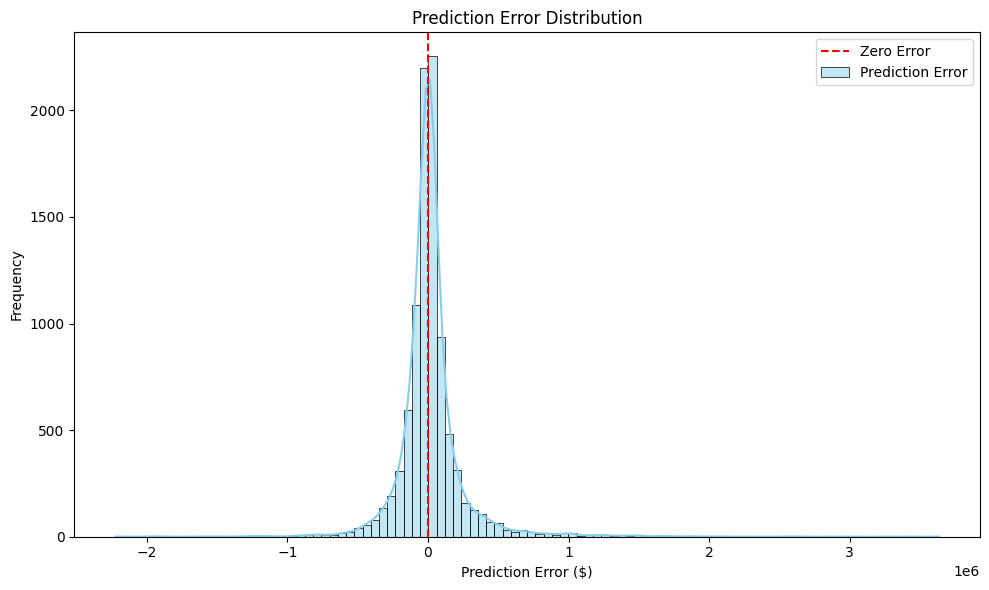

In [42]:
errors = y_true - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=100, kde=True, color='skyblue', label='Prediction Error')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Prediction Error ($)")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution")
plt.legend()
plt.tight_layout()
plt.show()

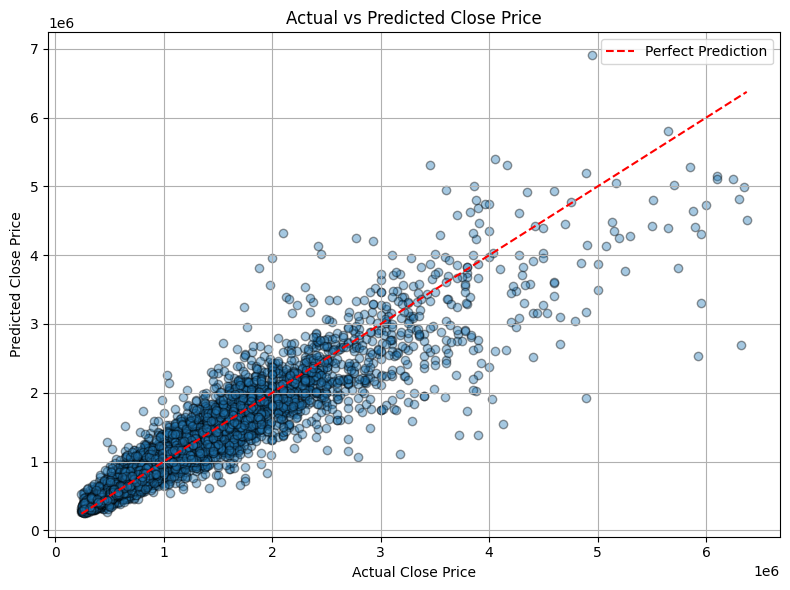

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.4, edgecolors="k")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color="red", linestyle="--", label="Perfect Prediction")
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title("Actual vs Predicted Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

According to the scatterplot, the model is not doing good on expensive-price houses.